## SMT Target Augmentation Strategy Analysis

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-10-09 11:16:09.153050: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-09 11:16:09.985832: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-09 11:16:10.590221: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-09 11:16:10.591017: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instruc

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run
from sim.wandb_scrape import *

  gene2vec_df = pd.read_csv(self.gene2vec_path, sep='\s+', header=None, index_col=0)



#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 4.3%
RAM Usage: 3.1%
Available RAM: 1.4T
Total RAM: 1.5T
52.4G


## Wandb Query <a id="sims"></a>

In [5]:
def fetch_and_summarize_wandb_runs_smt(model, cv_type, null_model, sort_genes='refgenome', token_encoder_dim=60, alibi_slopes=True, aug_prob=0.3, aug_style='linear_decay', feature_type='transcriptome', target='FC', within_last=60, before_last=0, use_weighted=False, exclude='HCP', return_history=False):
    """
    Fetches wandb runs matching specific tags and summarizes their final train/test metrics.
    Handles different CV types with their expected number of runs:
    - random/spatial: 40 runs
    - schaefer: 9 runs  
    - lobe: 6 runs
    
    Args:
        model (str): Model name, e.g., 'bilinear_CM'
        cv_type (str): CV type, one of: 'random', 'spatial', 'schaefer', 'lobe'
        null_model (str): Null model label, e.g., 'none'
        feature_type (str): Feature type, e.g., 'transcriptome_PCA'
        target (str): Target connectome type, e.g., 'FC'
        within_last (int): Search for runs within this many days ago (default: 60)
        before_last (int): Exclude runs from this many days ago (default: 0)
        use_weighted (bool): Whether to compute weighted statistics for schaefer/lobe CV
        exclude (str): Dataset to exclude from search (default: 'HCP')
        return_history (bool): If True, return (summary_df, history_df) tuple
    
    Returns:
        summary_df (pd.DataFrame): DataFrame with mean, std, stderr of all train/test metrics
                                  If use_weighted=True and cv_type in ['schaefer', 'lobe'], 
                                  includes weighted_mean and weighted_stderr rows
        history_df (pd.DataFrame): Individual run data (only returned if return_history=True)
    """
    # Set time filters
    end_time = datetime.now() - timedelta(days=before_last)
    start_time = datetime.now() - timedelta(days=within_last)
    
    # Set expected number of runs based on cv_type
    if cv_type == "schaefer":
        expected_runs = 9
    elif cv_type == "lobe":
        expected_runs = 6
    else:  # random or spatial
        expected_runs = 40
    filters = {
        "tags": {
            "$all": [
                "final_eval",
                f"model_{model}",
                f"target_{target}",
                f"cv_type_{cv_type}",
                f"null_model_{null_model}",
                f"feature_type_{feature_type}", 
                f"sort_genes_{sort_genes}"
            ],
        },
        "config.token_encoder_dim": token_encoder_dim,
        "config.use_alibi": alibi_slopes,
        "config.aug_prob": aug_prob,
        "config.aug_style": aug_style,
        "created_at": {
            "$gte": start_time.isoformat(), 
            "$lte": end_time.isoformat()
        },
        "state": "finished"
    }
    
    # Add exclusion filter if specified
    if exclude != "":
        filters["tags"]["$nin"] = [f"dataset_{exclude}"]
    
    print(f"🔍 Fetching runs for: model={model}, cv_type={cv_type}, null_model={null_model}, feature_type={feature_type}")
    runs = api.runs(project_path, filters=filters, order="-created_at")
    
    run_data = []
    for run in runs:
        metrics = {}
        summary = run.summary

        # Attempt to extract the pearson_r value (or set to NaN if missing)
        pearson = summary.get("final_test_metrics", {}).get("pearson_r", np.nan)

        # Only consider runs with meaningful final_test_metrics
        if "final_test_metrics" not in summary:
            continue
        
        for k, v in summary.get('final_train_metrics', {}).items():
            if isinstance(v, (int, float)):
                metrics[f'train_{k}'] = v

        for k, v in summary.get('final_test_metrics', {}).items():
            if isinstance(v, (int, float)):
                metrics[f'test_{k}'] = v

        metrics['run_name'] = run.name
        metrics['run_id'] = run.id
        metrics['final_test_pearson_r'] = pearson
        
        # Extract fold number for weighted calculations
        if use_weighted and cv_type in ['schaefer', 'lobe']:
            fold_match = re.search(r'fold(\d+)', run.name)
            if fold_match:
                metrics['fold'] = int(fold_match.group(1))
        
        run_data.append(metrics)
    
    df = pd.DataFrame(run_data)

    print(f"📊 Found {len(df)} total runs")

    if len(df) < expected_runs:
        raise ValueError(f"❌ Expected {expected_runs} runs, but found {len(df)}.")

    # Handle deduplication based on CV type
    if use_weighted and cv_type in ['schaefer', 'lobe']:
        # Sort by fold number for proper weight assignment
        df = df.sort_values('fold')
        # Deduplicate by fold keeping highest test pearson_r within each fold
        df_unique = (
            df.sort_values(["fold", "final_test_pearson_r"], ascending=[True, False])
              .drop_duplicates("fold", keep="first")
        )
        print(f"📊 After deduplication: {len(df_unique)} unique runs")
        if len(df_unique) != expected_runs:
            raise ValueError(f"❌ Expected {expected_runs} unique folds, found {len(df_unique)} after deduplication.")
    else:
        # Deduplicate by run_name using highest test pearson_r
        df_unique = (
            df.sort_values("final_test_pearson_r", ascending=False)
              .drop_duplicates("run_name", keep="first")
        )
        print(f"📊 After deduplication: {len(df_unique)} unique runs")
        if len(df_unique) != expected_runs:
            raise ValueError(f"❌ Expected {expected_runs} unique run names, found {len(df_unique)} after deduplication.")

    # Store history before cleaning for aggregation
    history_df = df_unique.copy()
    
    # Clean and summarize
    columns_to_drop = ["run_name", "run_id", "final_test_pearson_r"]
    if 'fold' in df_unique.columns:
        columns_to_drop.append("fold")
    df_clean = df_unique.drop(columns=columns_to_drop, errors="ignore")

    summary_df = pd.DataFrame({
        "mean": df_clean.mean(),
        "std": df_clean.std(),
        "stderr": df_clean.sem()
    }).T
    
    # Add weighted statistics if requested and applicable
    if use_weighted and cv_type in ['schaefer', 'lobe']:
        weights = list(CV_WEIGHTS[cv_type].values())
        
        # Calculate weighted statistics for final_test_pearson_r
        weighted_mean, weighted_se = weighted_mean_and_se(df_unique['final_test_pearson_r'].values, weights)
        summary_df.loc['weighted_mean', 'final_test_pearson_r'] = weighted_mean
        summary_df.loc['weighted_stderr', 'final_test_pearson_r'] = weighted_se
        
        # Calculate weighted statistics for test_pearson_r if it exists
        if 'test_pearson_r' in df_clean.columns:
            test_pearson_values = df_unique['test_pearson_r'].values if 'test_pearson_r' in df_unique.columns else df_clean['test_pearson_r'].values
            weighted_mean_test, weighted_se_test = weighted_mean_and_se(test_pearson_values, weights)
            summary_df.loc['weighted_mean', 'test_pearson_r'] = weighted_mean_test
            summary_df.loc['weighted_stderr', 'test_pearson_r'] = weighted_se_test

    if return_history:
        return summary_df, history_df
    else:
        return summary_df


Random

In [6]:
def plot_smt_augmentation_performance(results, cv_type, metric='test_mse', ymin=None, ymax=None):
    # Get list of augmentation strategies from results
    aug_styles = list(results.keys())
    
    # Reorder aug_styles to group curriculum and non-curriculum strategies
    ordered_styles = []
    curriculum_styles = []
    basic_styles = []
    
    for style in aug_styles:
        if style == 'none':
            continue
        elif 'curriculum' in style:
            curriculum_styles.append(style)
        else:
            basic_styles.append(style)
    
    ordered_styles = ['none'] + basic_styles + curriculum_styles
    
    n_styles = len(ordered_styles)
    
    # Create readable labels by replacing underscores with spaces and capitalizing
    labels = [' '.join(word.capitalize() for word in style.split('_')) for style in ordered_styles]
    
    # Create figure
    plt.figure(figsize=(15, 6))

    # Set width of bars and positions
    bar_width = 0.3
    base_positions = np.arange(1)  # For the token dimension
    
    # Darker pastel colors
    colors = []
    for style in ordered_styles:
        if style == 'none':
            colors.append('#B3D9FF')  # Darker light blue
        elif 'curriculum' in style:
            # Darker oranges
            if 'linear_increase' in style:
                colors.append('#FFB366')  # Darker light orange
            elif 'constant' in style:
                colors.append('#FF9933')  # Darker medium orange
            else:
                colors.append('#FF8000')  # Darker orange
        else:
            # Darker greens
            if 'linear_decay' in style:
                colors.append('#99CC99')  # Darker light green
            elif 'constant' in style:
                colors.append('#66B266')  # Darker medium green
            elif 'linear_increase' in style:
                colors.append('#339933')  # Darker green
            else:
                colors.append('#008000')  # Darkest green

    # Get all means and errors to determine y-axis limits if not provided
    all_means = []
    all_errs = []
    for style in ordered_styles:
        means = [results[style].loc['mean', metric]]
        errs = [results[style].loc['stderr', metric]]
        all_means.extend(means)
        all_errs.extend(errs)

    # Calculate y-axis limits with padding based on max standard error if not provided
    if ymin is None or ymax is None:
        min_val = min(all_means)
        max_val = max(all_means)
        max_err = max(all_errs)
        y_min = min_val - 3*max_err if ymin is None else ymin
        y_max = max_val + 3*max_err if ymax is None else ymax
    else:
        y_min = ymin
        y_max = ymax

    # Get baseline performance ('none' augmentation)
    baseline_mean = results['none'].loc['mean', metric]

    # Plot bars for each augmentation strategy
    for i, (style, label, color) in enumerate(zip(ordered_styles, labels, colors)):
        means = [results[style].loc['mean', metric]]
        errs = [results[style].loc['stderr', metric]]
        
        positions = [x + i*bar_width for x in base_positions]
        bars = plt.bar(positions, means, bar_width, yerr=errs, capsize=3,
                      label=label, color=color, alpha=0.8)
        
        # Add value labels with extra decimal place for MSE
        for idx, rect in enumerate(bars):
            height = rect.get_height()
            if metric == 'test_mse':
                plt.text(rect.get_x() + rect.get_width()/2., height + errs[idx],
                        f'{means[idx]:.4f}'[1:],
                        ha='center', va='bottom', rotation=0, fontsize=12)
            else:
                plt.text(rect.get_x() + rect.get_width()/2., height + errs[idx],
                        f'{means[idx]:.3f}'[1:],
                        ha='center', va='bottom', rotation=0, fontsize=12)

    # Add dashed line for baseline performance
    plt.axhline(y=baseline_mean, color='gray', linestyle='--', alpha=0.5, label='Baseline (No Aug.)')

    # Customize plot
    plt.ylabel(f'{metric}')
    plt.title(f'Mean {cv_type} Split Performance by Augmentation Strategy ({metric})')
    plt.xticks([base_positions[0] + (n_styles-1)*bar_width/2], ['60 dim'])
    plt.legend(loc='upper left', prop={'size': 12}, ncol=2)
    plt.ylim(y_min, y_max)

    # Show plot
    plt.tight_layout()
    plt.show()

In [7]:
# Setup common parameters
cv_type = 'random'
null_model = 'none'
before_last = -1
within_last = 10
model_type = 'shared_transformer'

sort_genes = 'refgenome'
alibi_slopes = True
token_encoder_dim = 60

random_results = {}

aug_styles = [ 'none', 'linear_decay', 'constant', 'linear_increase', 'linear_peak', 'curriculum_swap_linear_increase', 'curriculum_swap_constant', 'curriculum_swap_linear_decay', 'none']

for aug_style in aug_styles:
    sort_genes = 'refgenome'
    random_results[f'{aug_style}'] = fetch_and_summarize_wandb_runs_smt(
        model_type, cv_type, null_model, sort_genes=sort_genes,
        token_encoder_dim=token_encoder_dim, alibi_slopes=alibi_slopes,
        feature_type='transcriptome', target='FC', aug_style=aug_style,
        within_last=within_last, before_last=before_last
    )


🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique run

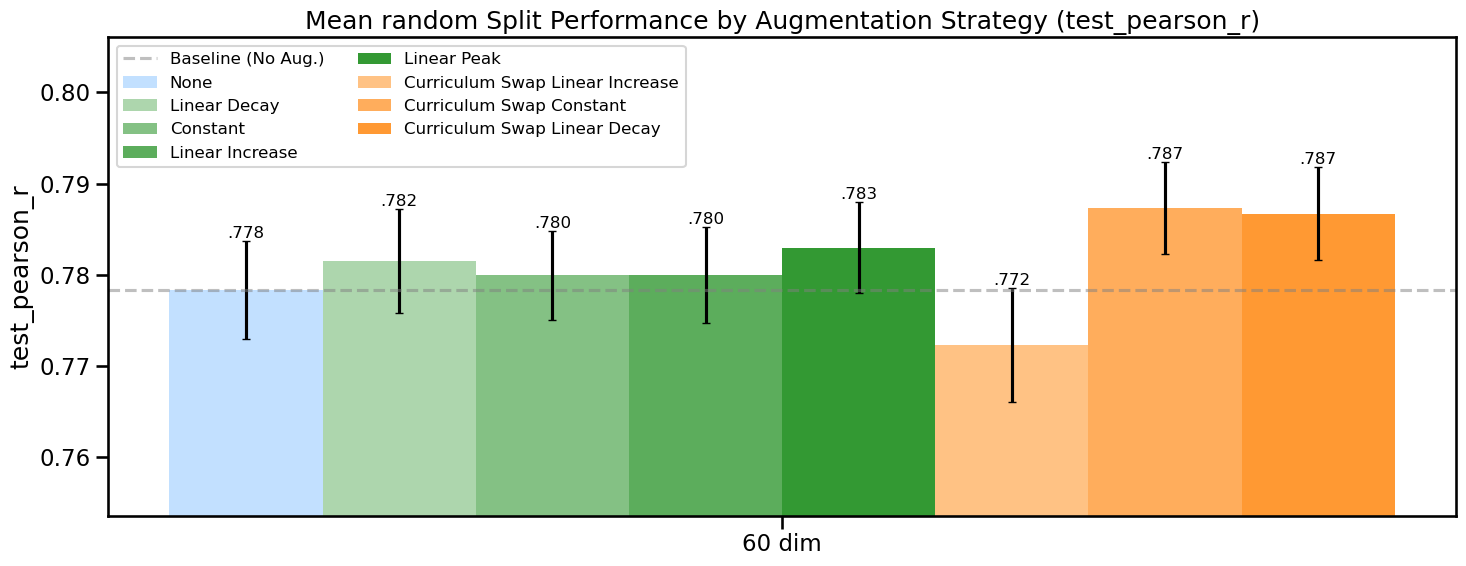

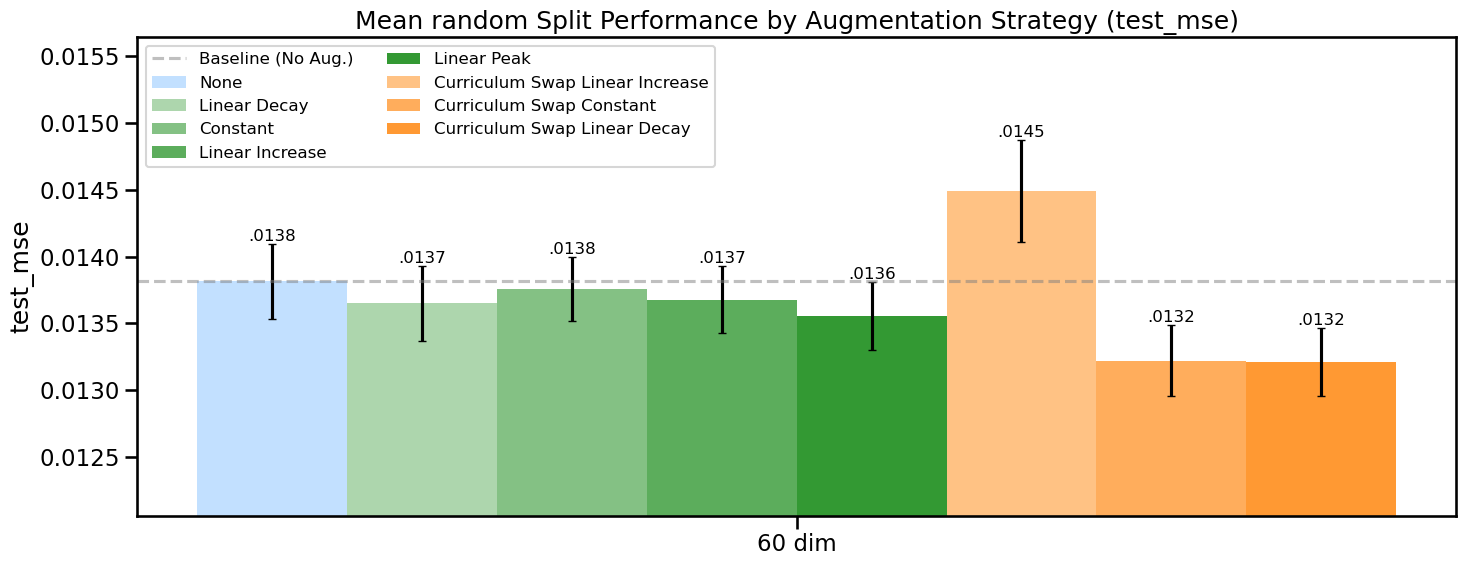

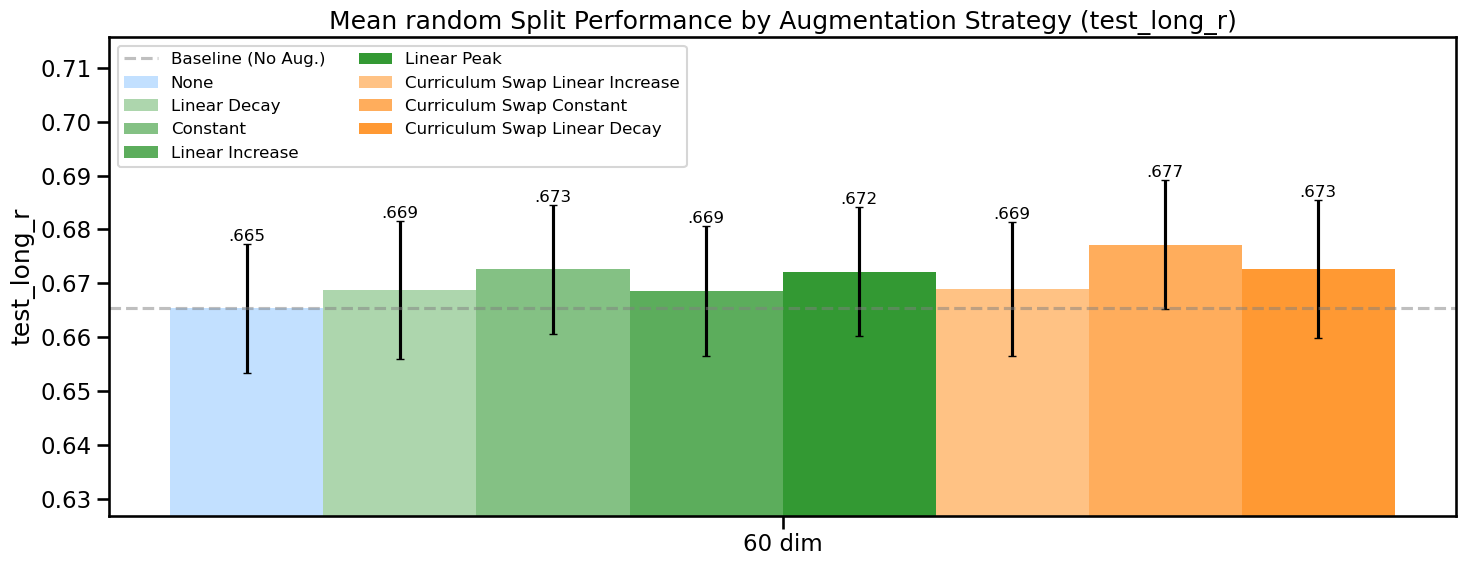

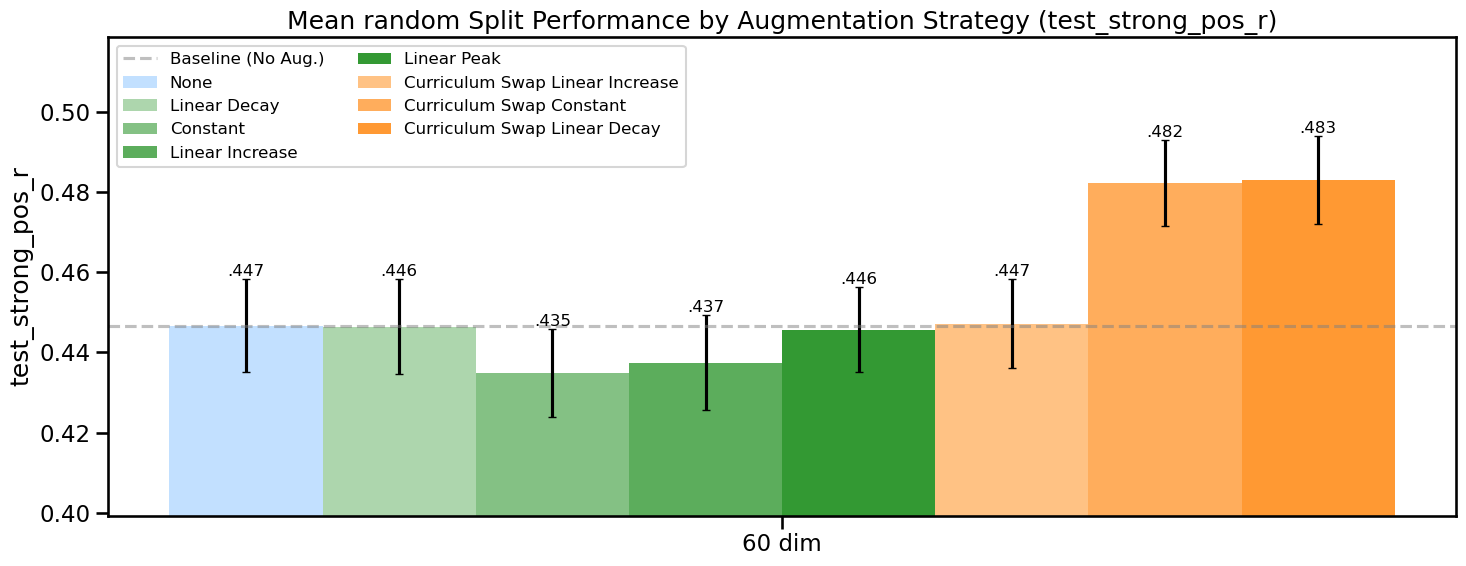

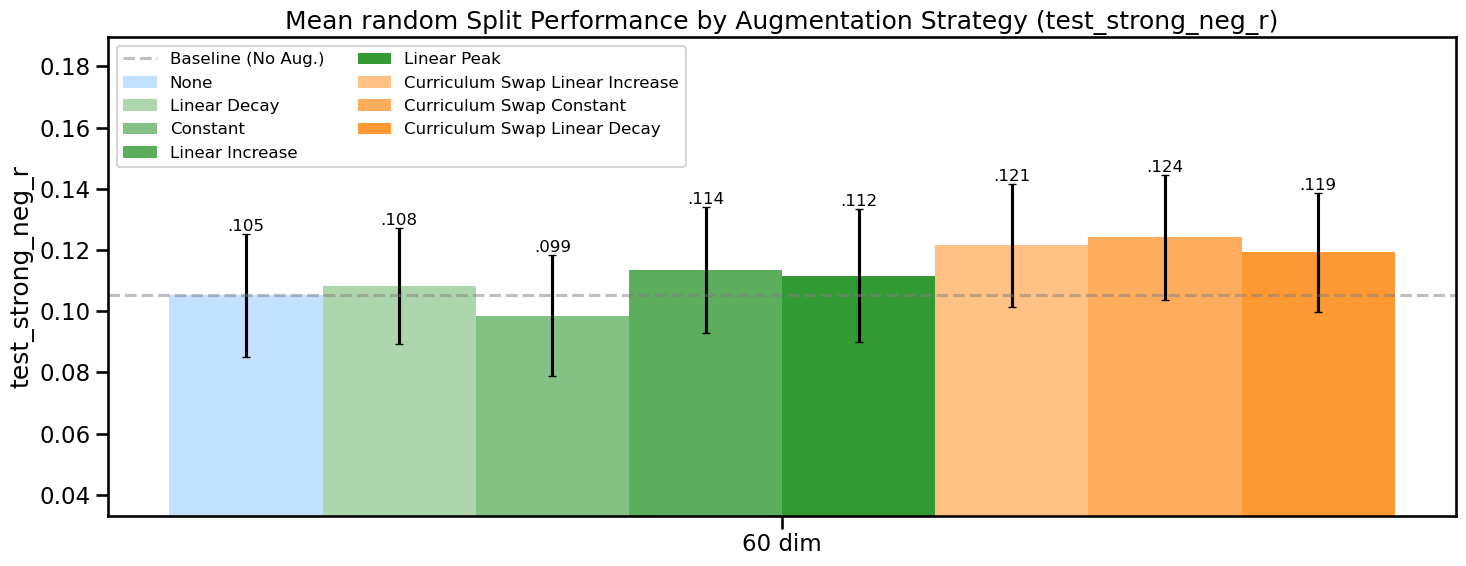

In [8]:
plot_smt_augmentation_performance(random_results, cv_type='random', metric='test_pearson_r')
plot_smt_augmentation_performance(random_results, cv_type='random', metric='test_mse')
plot_smt_augmentation_performance(random_results, cv_type='random', metric='test_long_r')
plot_smt_augmentation_performance(random_results, cv_type='random', metric='test_strong_pos_r')
plot_smt_augmentation_performance(random_results, cv_type='random', metric='test_strong_neg_r')


🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs


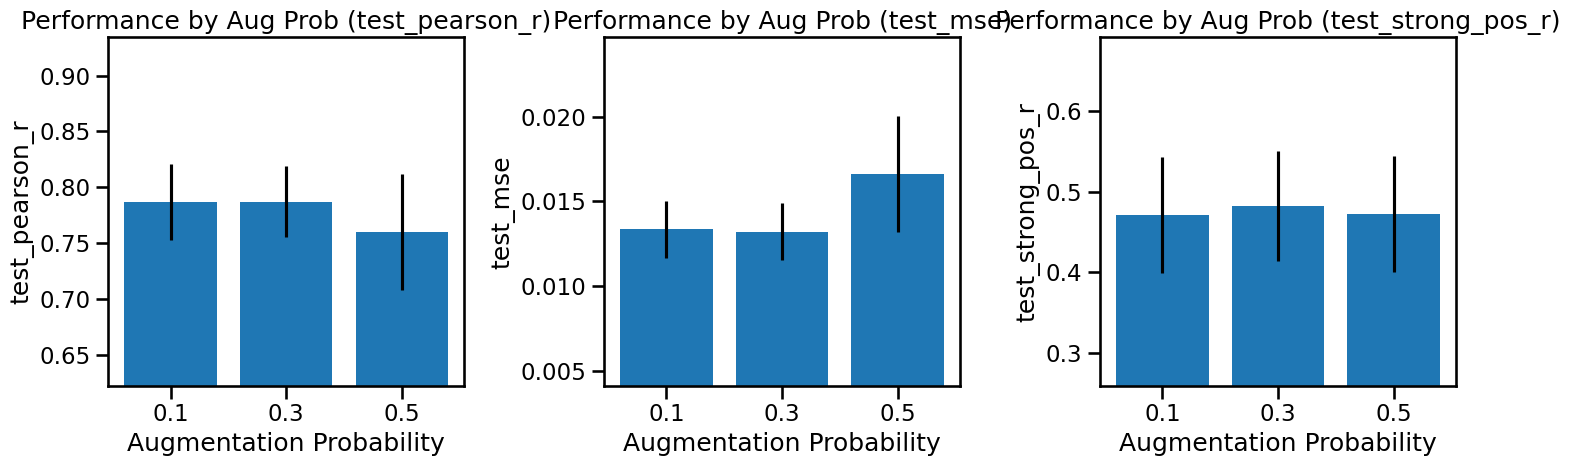

In [11]:
# Store results for different augmentation probabilities
aug_prob_results = {}

aug_prob_results['0.1'] = fetch_and_summarize_wandb_runs_smt(model_type, cv_type, null_model, sort_genes=sort_genes,
        token_encoder_dim=token_encoder_dim, alibi_slopes=alibi_slopes,
        feature_type='transcriptome', target='FC', aug_prob=0.1, aug_style='curriculum_swap_constant',
        within_last=within_last, before_last=before_last)

aug_prob_results['0.3'] = fetch_and_summarize_wandb_runs_smt(model_type, cv_type, null_model, sort_genes=sort_genes,
        token_encoder_dim=token_encoder_dim, alibi_slopes=alibi_slopes,
        feature_type='transcriptome', target='FC', aug_prob=0.3, aug_style='curriculum_swap_constant',
        within_last=within_last, before_last=before_last)

aug_prob_results['0.5'] = fetch_and_summarize_wandb_runs_smt(model_type, cv_type, null_model, sort_genes=sort_genes,
        token_encoder_dim=token_encoder_dim, alibi_slopes=alibi_slopes,
        feature_type='transcriptome', target='FC', aug_prob=0.5, aug_style='curriculum_swap_constant',
        within_last=within_last, before_last=before_last)

# Plot bar charts for selected metrics
metrics = ['test_pearson_r', 'test_mse', 'test_strong_pos_r']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics):
    values = [aug_prob_results[prob][metric]['mean'] for prob in ['0.1', '0.3', '0.5']]
    errors = [aug_prob_results[prob][metric]['std'] for prob in ['0.1', '0.3', '0.5']]
    
    # Calculate y-axis limits based on data
    mean_val = np.mean(values)
    max_std = np.max(errors)
    y_min = mean_val - 3*max_std
    y_max = mean_val + 3*max_std
    
    axes[i].bar(['0.1', '0.3', '0.5'], values, yerr=errors)
    axes[i].set_title(f'Performance by Aug Prob ({metric})')
    axes[i].set_xlabel('Augmentation Probability')
    axes[i].set_ylabel(metric)
    axes[i].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

Spatial

In [12]:
# Setup common parameters
cv_type = 'spatial'
null_model = 'none'
before_last = -1
within_last = 10
model_type = 'shared_transformer'

sort_genes = 'refgenome'
alibi_slopes = True
token_encoder_dim = 60

spatial_results = {}

aug_styles = [ 'none', 'linear_decay', 'constant', 'linear_increase', 'linear_peak', 'curriculum_swap_linear_increase', 'curriculum_swap_constant', 'curriculum_swap_linear_decay']
for aug_style in aug_styles:
    sort_genes = 'refgenome'
    spatial_results[f'{aug_style}'] = fetch_and_summarize_wandb_runs_smt(
        model_type, cv_type, null_model, sort_genes=sort_genes,
        token_encoder_dim=token_encoder_dim, alibi_slopes=alibi_slopes,
        feature_type='transcriptome', target='FC', aug_style=aug_style,
        within_last=within_last, before_last=before_last
    )

🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 42 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 uniq

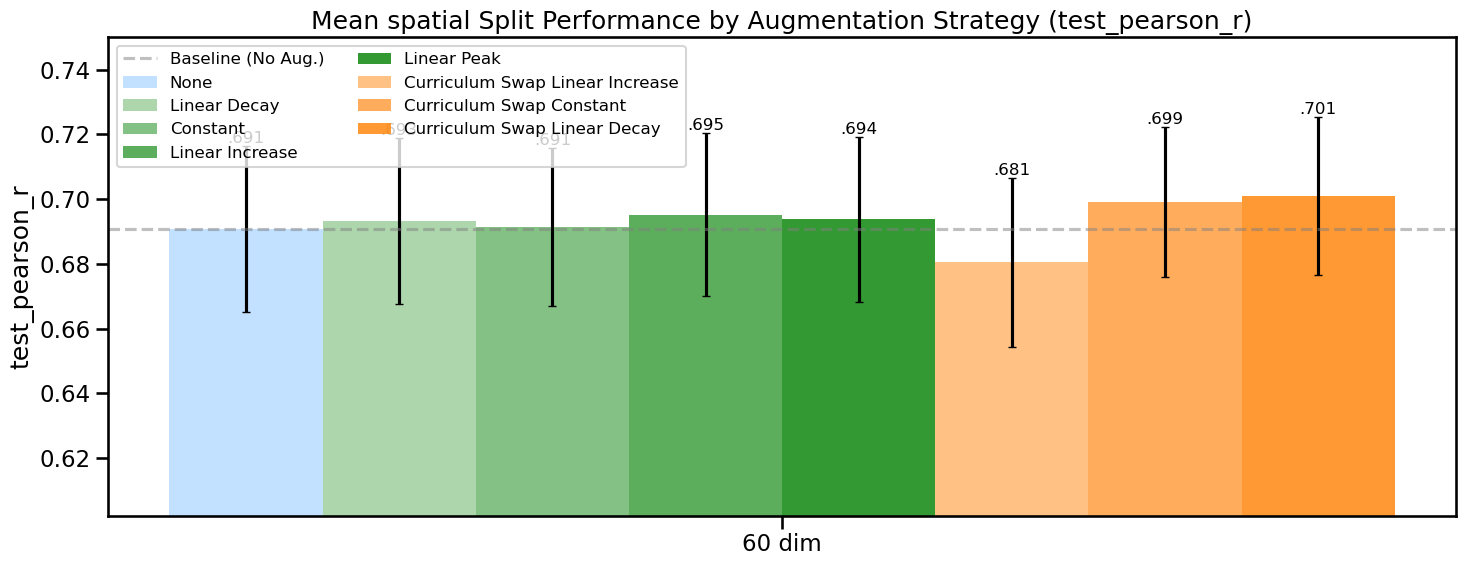

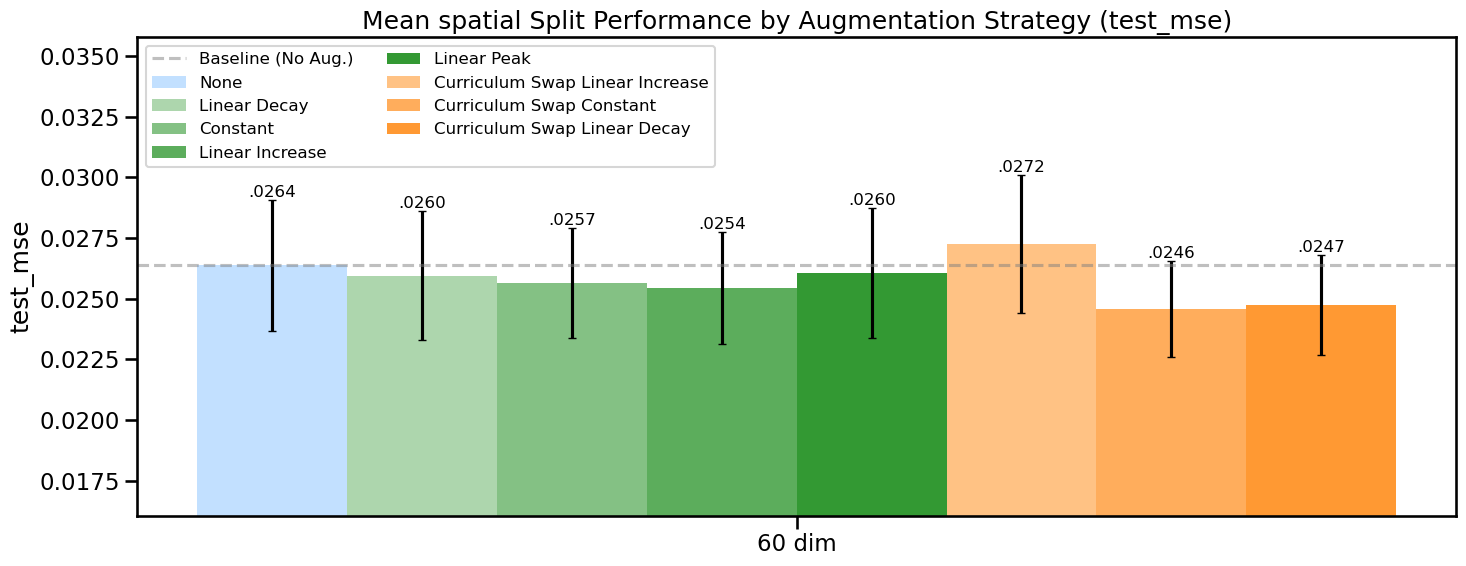

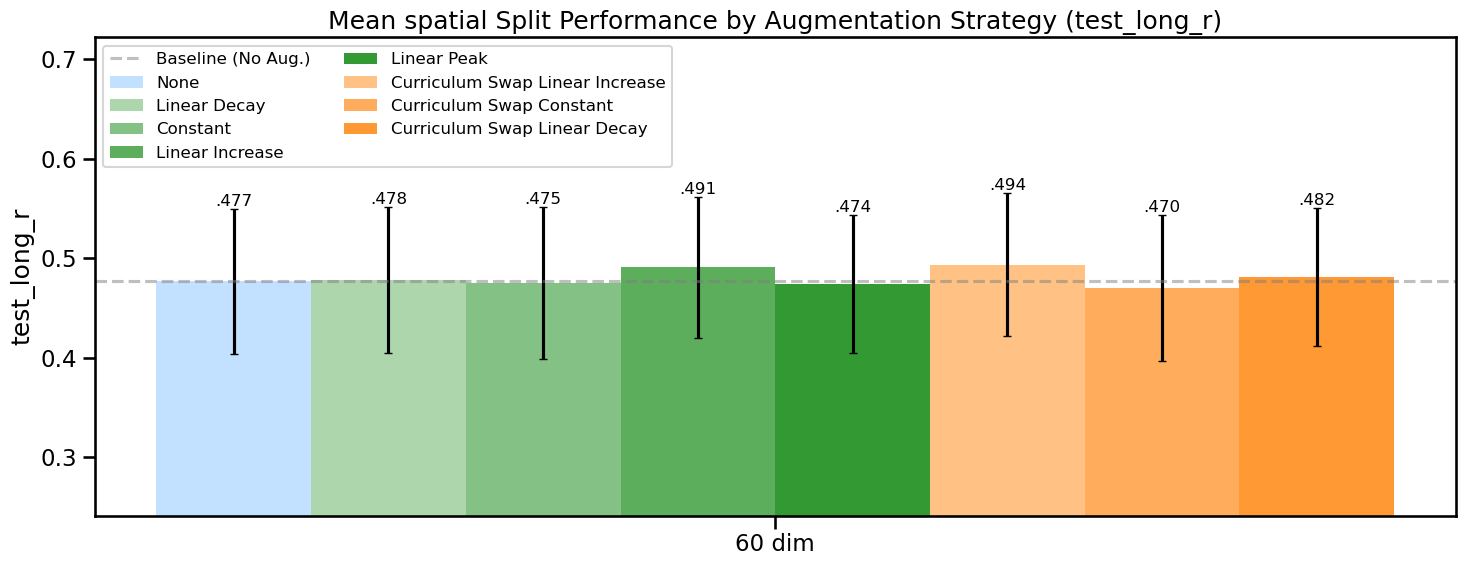

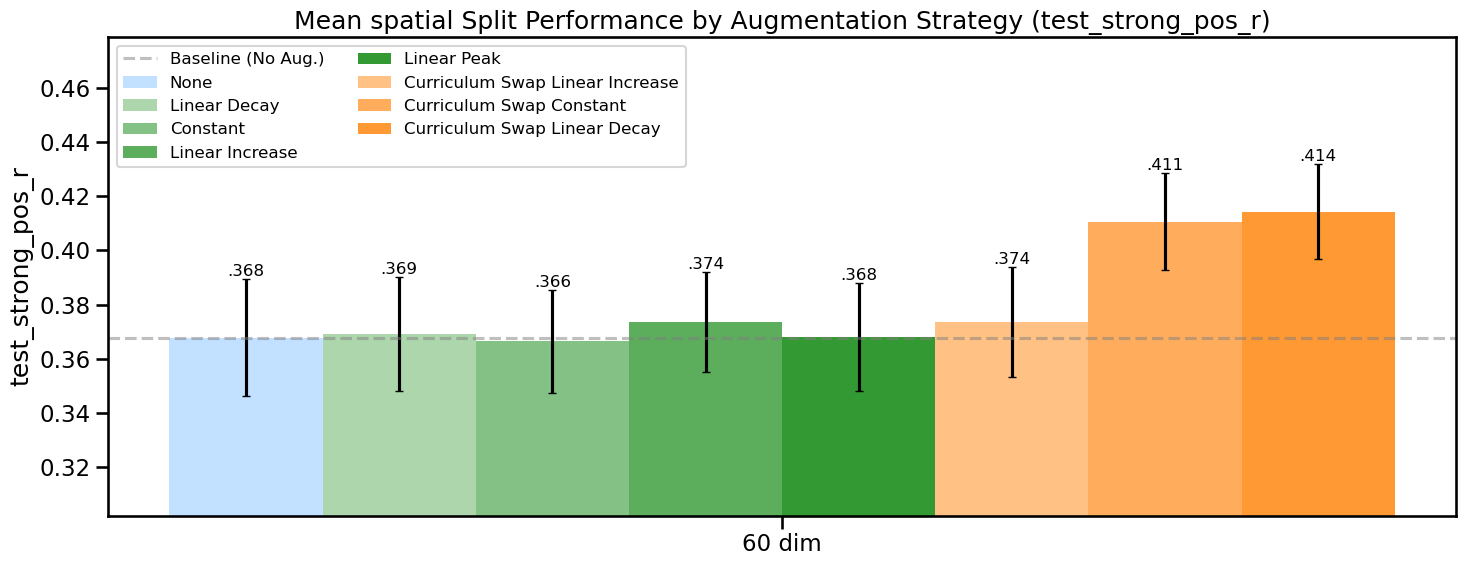

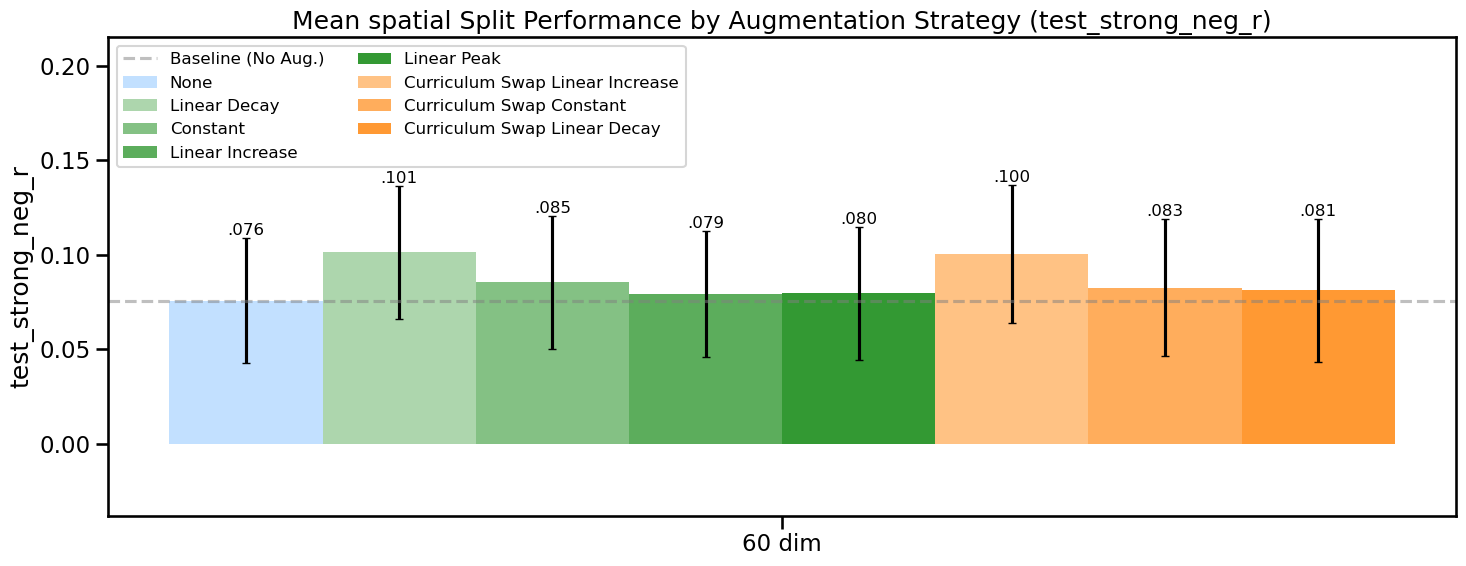

In [13]:
plot_smt_augmentation_performance(spatial_results, cv_type='spatial', metric='test_pearson_r', ymax=0.75)
plot_smt_augmentation_performance(spatial_results, cv_type='spatial', metric='test_mse')
plot_smt_augmentation_performance(spatial_results, cv_type='spatial', metric='test_long_r')
plot_smt_augmentation_performance(spatial_results, cv_type='spatial', metric='test_strong_pos_r')
plot_smt_augmentation_performance(spatial_results, cv_type='spatial', metric='test_strong_neg_r')


🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 41 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs


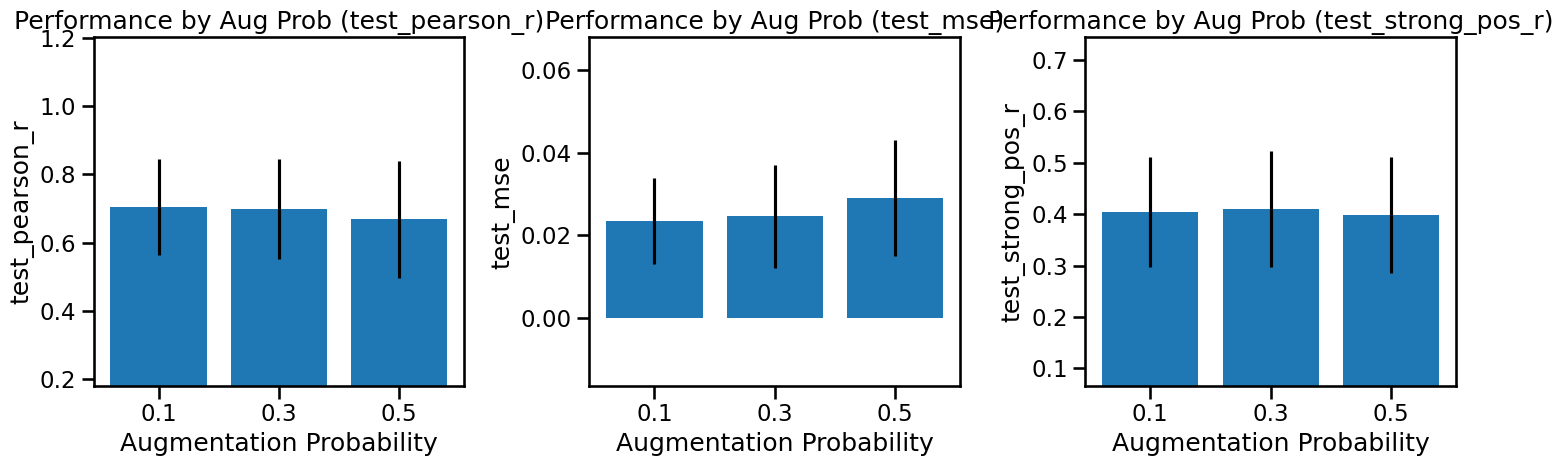

In [14]:
# Store results for different augmentation probabilities
aug_prob_results = {}

aug_prob_results['0.1'] = fetch_and_summarize_wandb_runs_smt(model_type, cv_type, null_model, sort_genes=sort_genes,
        token_encoder_dim=token_encoder_dim, alibi_slopes=alibi_slopes,
        feature_type='transcriptome', target='FC', aug_prob=0.1, aug_style='curriculum_swap_constant',
        within_last=within_last, before_last=before_last)

aug_prob_results['0.3'] = fetch_and_summarize_wandb_runs_smt(model_type, cv_type, null_model, sort_genes=sort_genes,
        token_encoder_dim=token_encoder_dim, alibi_slopes=alibi_slopes,
        feature_type='transcriptome', target='FC', aug_prob=0.3, aug_style='curriculum_swap_constant',
        within_last=within_last, before_last=before_last)

aug_prob_results['0.5'] = fetch_and_summarize_wandb_runs_smt(model_type, cv_type, null_model, sort_genes=sort_genes,
        token_encoder_dim=token_encoder_dim, alibi_slopes=alibi_slopes,
        feature_type='transcriptome', target='FC', aug_prob=0.5, aug_style='curriculum_swap_constant',
        within_last=within_last, before_last=before_last)

# Plot bar charts for selected metrics
metrics = ['test_pearson_r', 'test_mse', 'test_strong_pos_r']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics):
    values = [aug_prob_results[prob][metric]['mean'] for prob in ['0.1', '0.3', '0.5']]
    errors = [aug_prob_results[prob][metric]['std'] for prob in ['0.1', '0.3', '0.5']]
    
    # Calculate y-axis limits based on data
    mean_val = np.mean(values)
    max_std = np.max(errors)
    y_min = mean_val - 3*max_std
    y_max = mean_val + 3*max_std
    
    axes[i].bar(['0.1', '0.3', '0.5'], values, yerr=errors)
    axes[i].set_title(f'Performance by Aug Prob ({metric})')
    axes[i].set_xlabel('Augmentation Probability')
    axes[i].set_ylabel(metric)
    axes[i].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()